In [1]:
pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=87453096e9a0aed7551559c01641abd3f028ba91ce8e8308f99e97f5584e2f3e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=012510c660434e2a4882004e89f79b852e612244360b001f58c5ea11d9061430
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

from time import sleep
from PIL import Image
import cv2
import os
from torch import nn

In [ ]:
! unzip '/content/mask.zip' -d '/content/folder'

In [6]:
DATA_ROOT = '/content/drive/MyDrive/dataset/set-lipstick-original/'

In [7]:
DATASET_PATH = '/content/drive/MyDrive/dataset/set-lipstick-original/list.csv'
DATA_PATH_FOR_MASK = '/content/folder/mask/'

In [8]:
df = pd.read_csv(DATASET_PATH)

In [9]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [10]:
indx = np.random.choice(np.arange(df.shape[0]))

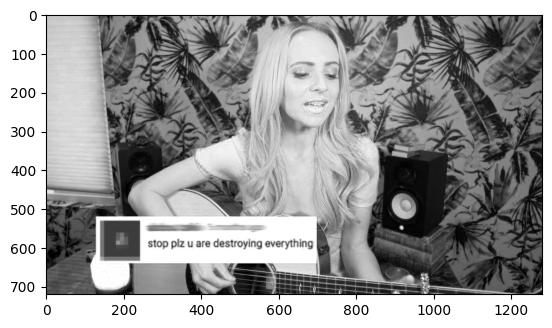

In [33]:
img = plt.imread(DATA_ROOT + f'720p/{df.loc[indx]["filename"]}')
plt.imshow(img[..., 0], cmap='gray')
plt.show()

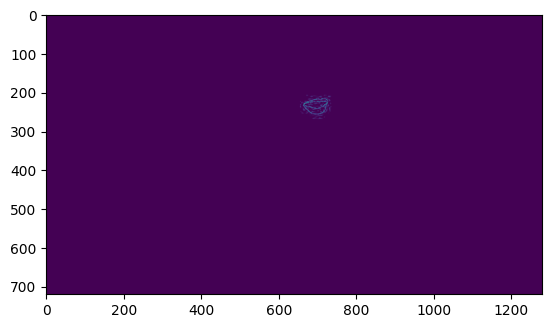

In [34]:
img = plt.imread(DATA_PATH_FOR_MASK + df.loc[indx]["mask"])
plt.imshow(img[..., 0])
plt.show()

In [35]:
df_1 = pd.DataFrame()

In [38]:
image_link = []
mask_link = []

for i in range(len(df.index)):
  im = DATA_ROOT + f'720p/{df.loc[i]["filename"]}'
  msk = DATA_PATH_FOR_MASK + df.loc[i]["mask"]
  image_link.append(im)
  mask_link.append(msk)

df_1['image'] = image_link
df_1['mask'] = mask_link

In [39]:
df_1.sort_values(by='image', inplace=True)
df_1.reset_index(drop=True, inplace=True)
df_1.head()

,image,mask
0,/content/drive/MyDrive/dataset/set-lipstick-or...,/content/folder/mask/mask00000001.png
1,/content/drive/MyDrive/dataset/set-lipstick-or...,/content/folder/mask/mask00000002.png
2,/content/drive/MyDrive/dataset/set-lipstick-or...,/content/folder/mask/mask00000003.png
3,/content/drive/MyDrive/dataset/set-lipstick-or...,/content/folder/mask/mask00000004.png
4,/content/drive/MyDrive/dataset/set-lipstick-or...,/content/folder/mask/mask00000005.png


In [40]:
class Set_lipstick(torch.utils.data.Dataset):
  def __init__(self, data, preprocessing=None):
    self.data = data
    self.image_arr = self.data.iloc[:,0]
    self.mask_arr = self.data.iloc[:,1]
    self.data_len = len(self.data.index)
    self.preprocessing = preprocessing

  def __getitem__(self, index):
    img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))

    img = np.asarray(img).astype('float')

    if self.preprocessing is not None:
      img = self.preprocessing(img)
      img = torch.as_tensor(img)
    else:
      img = torch.as_tensor(img) / 255.0
    img.permute(2,0,1)

    mask = cv2.imread(self.mask_arr[index])

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = Image.open(self.mask_arr[index])
    mask = mask.resize((256,256))
    mask = np.asarray(mask).astype('float')
    mask = torch.as_tensor(mask, dtype=torch.uint8)


    return (img.float(), mask)

  def __len__(self):
    return self.data_len

In [41]:
BACKBONE = 'resnet34'
segmodel = smp.Unet(BACKBONE, classes=3, activation='softmax2d')

In [42]:
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

In [49]:
indx = np.random.choice(np.arange(df.shape[0]))
indx

12725

torch.Size([256, 256, 3]) torch.Size([256, 256, 3])


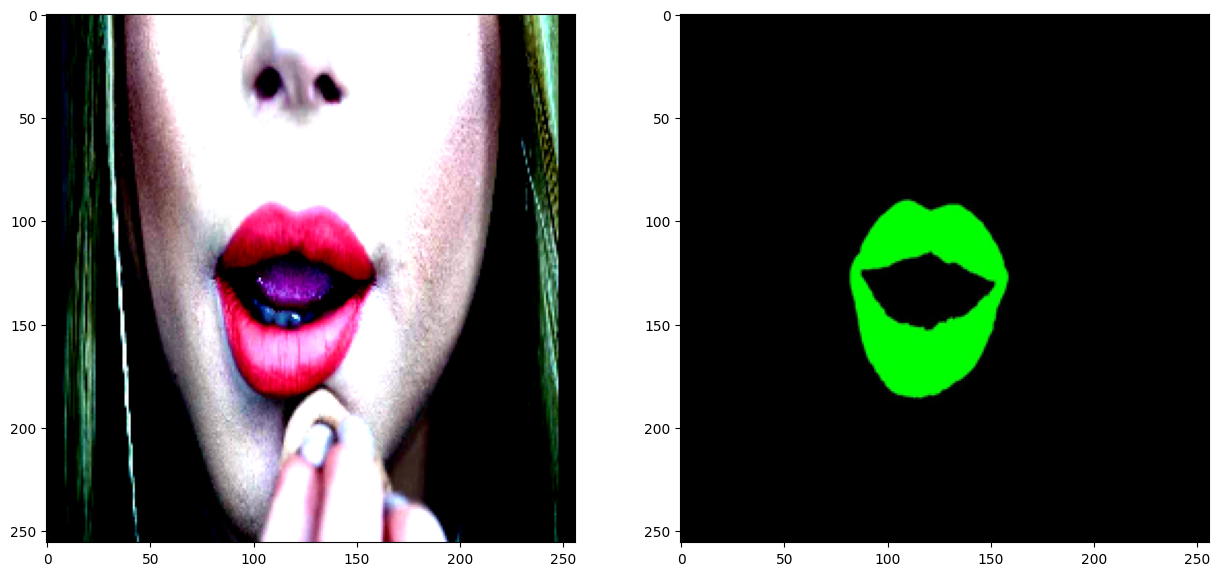

In [50]:
dataset = Set_lipstick(df_1, preprocessing=preprocess_input)
img, mask = dataset[indx]
print(img.shape, mask.shape)
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].imshow(img)
ax[1].imshow(mask)
plt.show()

In [61]:
X_train, X_test = train_test_split(df_1, test_size=0.3)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [62]:
X_train = Set_lipstick(X_train, preprocessing=preprocess_input)
X_test = Set_lipstick(X_test, preprocessing=preprocess_input)


In [53]:
train_loader = torch.utils.data.DataLoader(X_train,
                                           batch_size=1,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(X_test,
                                          batch_size=1,
                                          shuffle=False)

torch.Size([1, 256, 256, 3]) torch.Size([1, 256, 256, 3])
tensor(-2.1008) tensor(2.6400)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


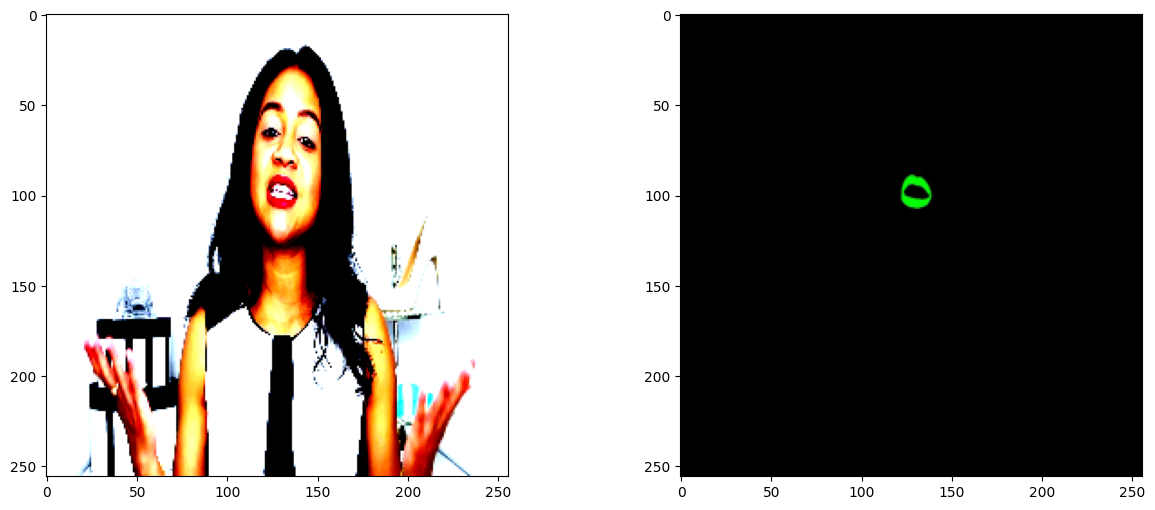

In [63]:
for img, mask in train_loader:

  print(img.shape, mask.shape)
  print(img[0].min(), img[0].max())
  print(mask[0].min(), mask[0].max())
  fig, ax = plt.subplots(1, 2,  figsize=(15, 6))
  ax[0].imshow(img[0])
  ax[1].imshow(mask[0])
  break

In [64]:
activation = nn.Softmax(dim=1)

In [65]:
criterion = smp.losses.DiceLoss(mode='binary')
metrics = [smp.losses.DiceLoss(mode='binary')]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.01)

Полностью обучить модель не получается, потому как на каком-то моменте происходит ошибка в подгрузке изображения(каждый раз на разных итерациях),

In [67]:
epochs = 1
epochs_losses = []
segmodel.train()

for epoch in range(epochs):
  epoch_loss = []

  for idx, (data,masks) in enumerate(train_loader):

    data, masks = data.permute(0,3,1,2), masks.permute(0,3,1,2)
    optimizer.zero_grad()
    outputs = segmodel(data)
    outputs = outputs.permute(0,2,3,1)

    loss = criterion(outputs.reshape(1,-1), masks.reshape(1,-1))

    epoch_loss.append(loss.item())


    if idx % 100 == 0:
            print(f'batch index : {idx} | loss : {loss.item()}')

  epochs_losses.append(epoch_loss)

batch index : 0 | loss : 0.834850549697876
batch index : 100 | loss : 0.7675025463104248


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
